In [1]:
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from tifffile import imwrite
from tqdm import tqdm
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy



/gpfs/home6/svstaalduine/AMF_project/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


/gpfs/scratch1/shared/amftrackflow/temp


2023-05-30 17:34:53.567309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 17:34:53.740283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home6/svstaalduine/.local/lib/python3.9/site-packages/cv2/../../lib64:/sw/arch/Centos8/EB_production/2021/software/ZeroMQ/4.3.4-GCCcore-10.3.0/lib:/sw/arch/Centos8/EB_production/2021/software/util-linux/2.36-GCCcore-10.3.0/lib:/sw/arch/Centos8/EB_production/2021/software/libsodium/1.0.18-GCCcore-10.3.0/lib:/sw/arch/Centos8/EB_production/2021/software/OpenPGM/5.2.122-GCCcore-10.3.0/lib:/sw

# Welcome to the video analysis pipeline module!

Use this notebook to extract kymographs and transport flows from raw video TIFFs. The first step is to supply some file parameters to make sure that the measurements are connected to real metrics and that the segmentation method is correct.

Important to note: 
Seg-Tresh is the limit of what percentage of the segmented image should be hypha. 

5
Found an xlsx file, using that data
              Unnamed: 0 Treatment Strain Time after crossing  \
6  20220118_Plate537_005  1%P100%N     C2              7 days   

   Growing temperature Position mm Unnamed: 6  dcenter mm  droot mm  \
6                 25.0       46260      43440         2.0       0.0   

  Bright-field (BF)\nor\nFluorescence (F) Binned (Y/N)  Magnification   FPS  \
6                                       F            Y           50.0  20.0   

   Video Length (s) Comments  
6              30.0      NaN  
Analysing FLUO video of 50.0X zoom, with 20.0 fps
Using image selection 0 to 600
Succesfully extracted the skeleton. Did you know there is a skeleton inside inside you right now?


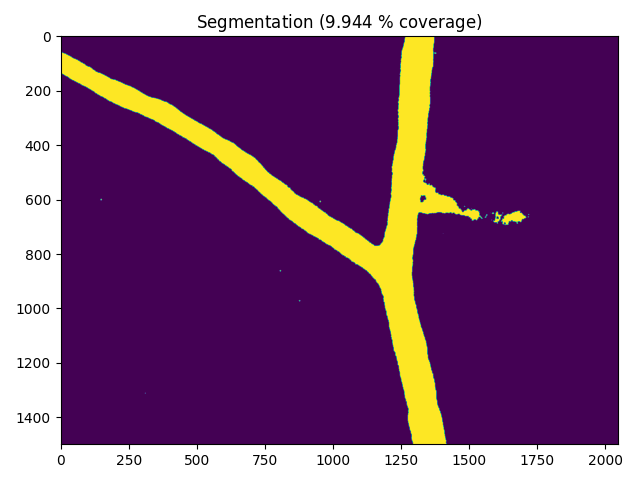

In [2]:

### This is where the video folder in question is supplied. If there is an excel file one level higher, 
### it will pull the relevant parameters from that.

img_address = '/gpfs/scratch1/shared/amftrackflow/Drp_downs/20230118_Plate537/20220118_Plate537_005'

### Logging     means that you will see print messages documenting the progress.
### vid_type    is either 'BRIGHT' or 'FLUO' for brightfield and fluorescence microscopy respectively. 
###                 Will be overruled if excel file is present
### fps         is the frames per second of the video
###                 Will be overruled if excel file is present
### binning     is whether the video was imaged at full resolution, or half resolution
###                 Will be overruled if excel file is present
### filter_step is not a known value
### seg_thresh  is the percentage coverage that the segmentation must achieve
### show_seg    if true will plot the segmentation image

test_video = Kymo_video_analysis(img_address, logging=True, vid_type=None, 
                                 fps=None, binning=None, filter_step=80,
                                seg_thresh=10, show_seg=True)
edge_list = test_video.edge_objects

If the segmentation is satisfactory, you can proceed with plotting the edges that will be analyzed. 


 To work with individual edges, here is a list of their indices:
edge 0, (64, 2)
edge 1, (64, 1)
edge 2, (71, 64)


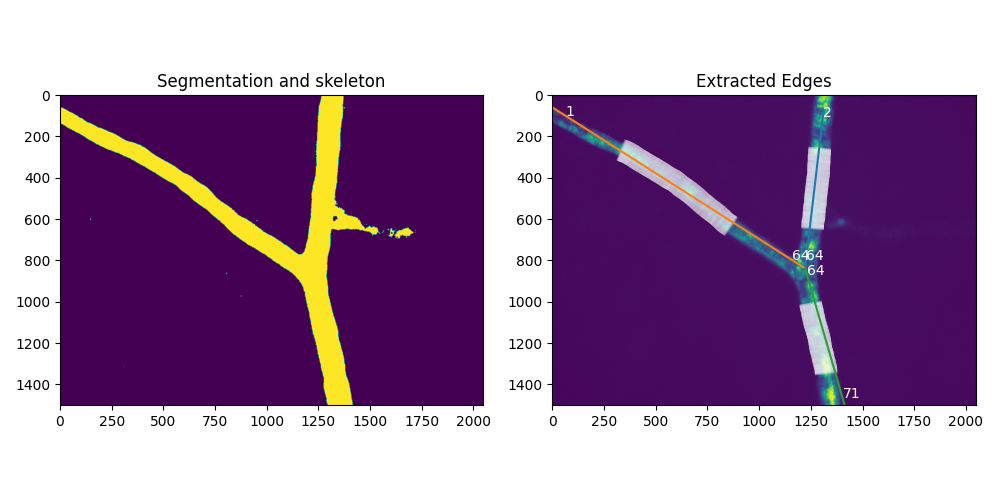

Saved the extracted edges


In [3]:
### The print statement will give you the edge indices such that you can select which edges to analyze.
print('\n To work with individual edges, here is a list of their indices:')
for i, edge in enumerate(edge_list):
    print('edge {}, {}'.format(i, edge.edge_name))
    
### Target length here determines the *width* of the analysis box. 
### Too shallow, and you won't capture the entire hypha, too big and the analysis is plagued with background.
target_length = int(1.9*test_video.magnification)

test_video.plot_extraction_img(target_length=target_length, save_img=True)
edges_total = test_video.edge_objects

## Below function will make an mp4 from the tiff files, can take a while, if you prefer to skip, that's fine.

In [ ]:
test_video.makeVideo()

## This is where you select the edges that you want to analyze.
Bin number creates a range of how the edges will be partitioned along their length.

In [4]:
edge_seq = [1]
# bin_nrs = np.arange(1,5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.34s/it]


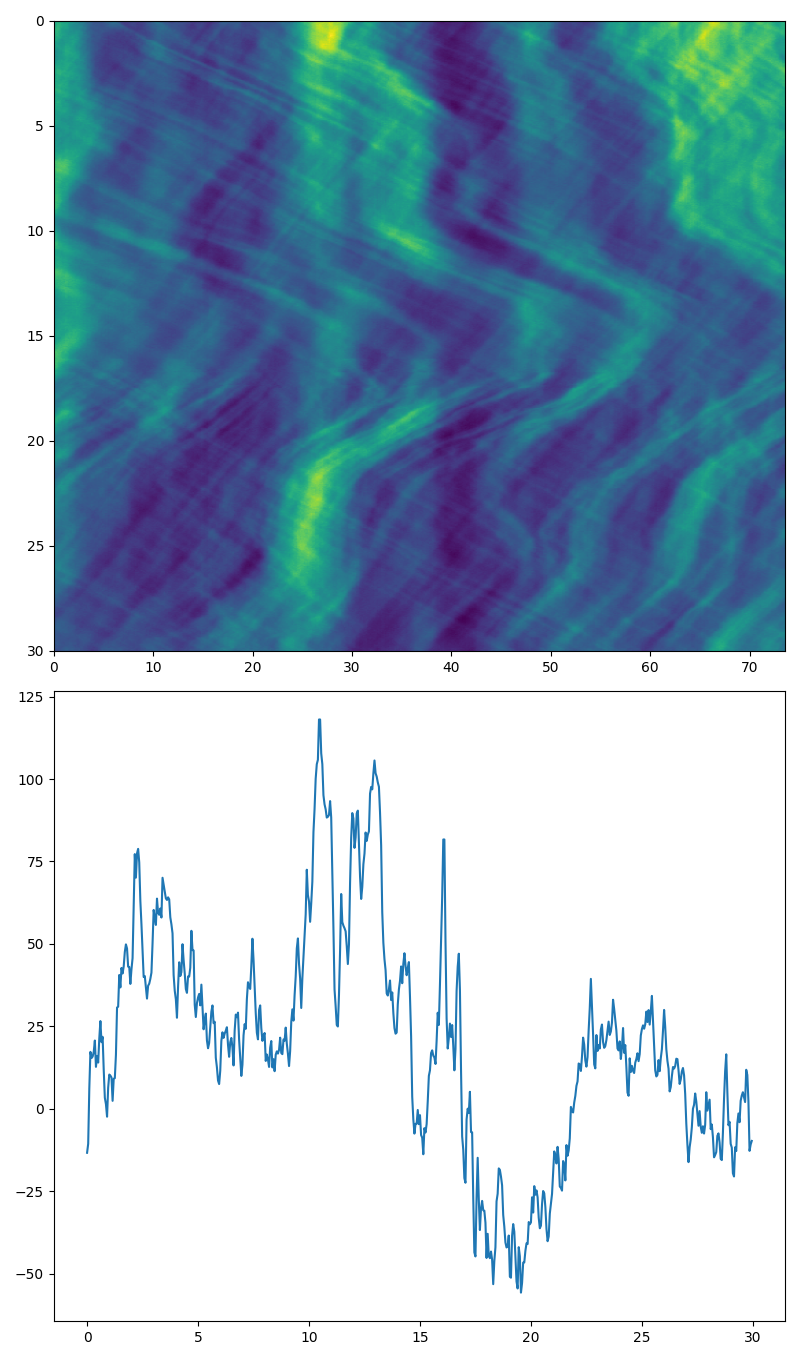

In [5]:
bin_nr = 1
edge_objs  = [edges_total[i] for i in edge_seq]
img_seq    = np.arange(len(edge_objs[0].video_analysis.selection_file))
kymos = []

### Exponential fit is performed to adjust for photobleaching
# exp_fit    = test_video.fit_backgr(img_seq, plots=True)

### A video and single frame will be made of each edge to get a closer look
# edge_pic   = edge.view_edge(img_frame=40 ,save_im=True, target_length = target_length)
# edge_video = edge.view_edge(img_frame = img_seq, save_im=True, quality = 6, target_length=target_length)

### Analysis consists of extracting a kymograph, doing fourier filtering, then extracting speeds, then transport.
### plots in each function turn on plt plots.
# for bin_nr in bin_nrs:    
for edge in edge_objs:
    space_res = edge.video_analysis.space_pixel_size
    time_res = edge.video_analysis.time_pixel_size
    video_kymos = edge.extract_multi_kymo(bin_nr, target_length=target_length, kymo_adj=False)
    kymos.append(video_kymos)
    imshow_extent = [0, edge.video_analysis.space_pixel_size * edge.kymos[0].shape[1],
                                  edge.video_analysis.time_pixel_size * edge.kymos[0].shape[0], 0]
    kymos_lefts, kymos_rights = edge.fourier_kymo(bin_nr, save_im=True, save_array=True)
    speeds, times = edge.test_GST(15, w_start=3, C_thresh=0.95, C_thresh_falloff = 0.001, blur_size = 5, preblur=True, speed_thresh=20, plots=False)    
    net_trans = edge.extract_transport(noise_thresh=0.15, plots=False, save_im=True, save_flux_array=True, margin=5)    

    fig, ax = plt.subplots(2, figsize=(8,8*1.7))
    ax[0].imshow(video_kymos[0], extent=imshow_extent, aspect='auto')
    ax[1].plot(times[0], np.nansum(net_trans, axis=1) / video_kymos[0].shape[1])
    fig.tight_layout()


## Experiment zone!!!


In [6]:
edge_table = {
                'edge_name': [],
                'edge_length': [],
                'straight_length': [],
                'speed_max': [],
                'speed_min': [],
                'flux_avg': [],
                'flux_min': [],
                'flux_max': [],                
             }
data_edge = pd.DataFrame(data=edge_table)

for edge in edge_objs:
    straight_len = np.linalg.norm((edge.segments[0][0] + edge.segments[0][1])/2 - (edge.segments[-1][0] + edge.segments[-1][1])/2)*space_res
    
    new_row = pd.DataFrame([{'edge_name':f'{edge.edge_name}', 
                             'edge_length': space_res *edge.kymos[0].shape[1],
                             'straight_length' : straight_len,
                             'speed_max' : np.nanpercentile(speeds[0][1], 97),
                             'speed_min' : np.nanpercentile(speeds[0][0], 3),
                             'flux_avg'  : np.nanmean(net_trans),
                             'flux_min'  : np.nanpercentile(net_trans, 3),
                             'flux_max'  : np.nanpercentile(net_trans, 97)
                            }])
    
    data_edge = pd.concat([data_edge, new_row])

data_edge

edge_name  edge_length  straight_length  speed_max  speed_min   flux_avg  \
0   (64, 1)       73.554        88.815411   9.112145  -4.828967  24.363197   

     flux_min    flux_max  
0 -178.580392  300.190977

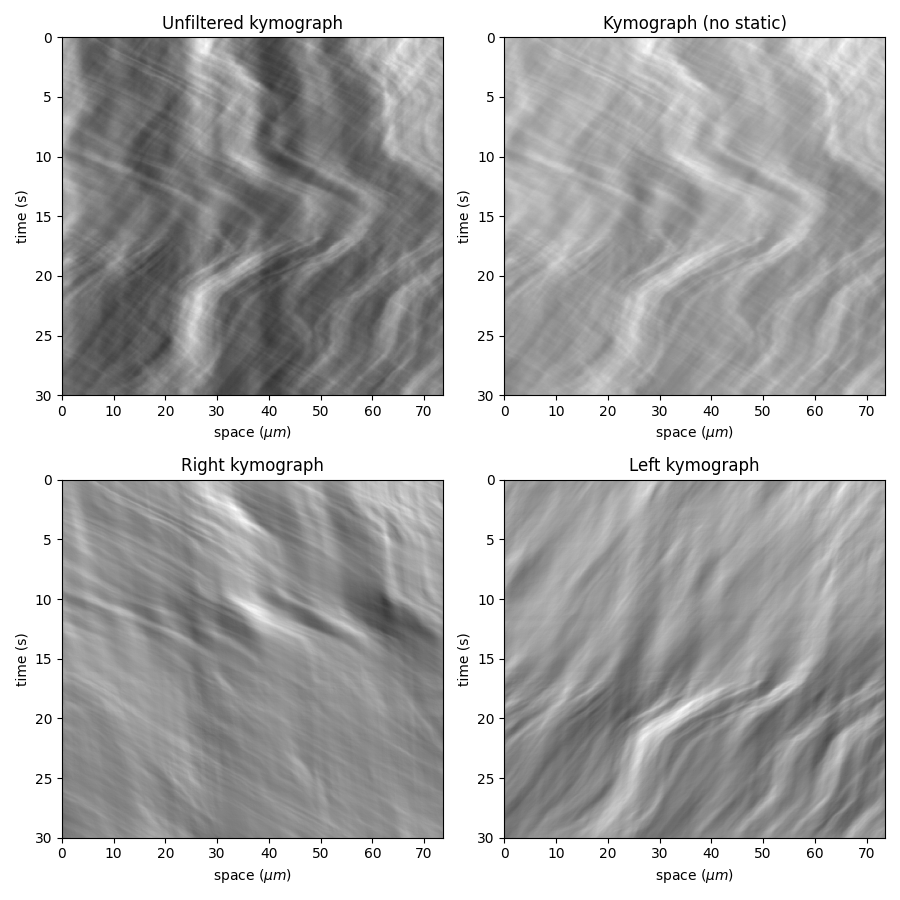

In [7]:
fig, ax = plt.subplots(2,2, figsize=(9,9))
ax[0][0].imshow(video_kymos[0], cmap='gray', vmin=0, aspect='auto', extent=imshow_extent)
ax[0][1].imshow((kymos_lefts[0]+ kymos_rights[0])/2, cmap='gray', vmin=0, aspect='auto', extent=imshow_extent)
ax[1][0].imshow(kymos_lefts[0], cmap='gray', vmin=0, aspect='auto', extent=imshow_extent)
ax[1][1].imshow(kymos_rights[0], cmap='gray', vmin=0, aspect='auto', extent=imshow_extent)

ax[0][0].set_title("Unfiltered kymograph")
ax[0][0].set_xlabel("space $(\mu m)$")
ax[0][0].set_ylabel("time (s)")
ax[0][1].set_title("Kymograph (no static)")
ax[0][1].set_xlabel("space $(\mu m)$")
ax[0][1].set_ylabel("time (s)")
ax[1][0].set_title("Right kymograph")
ax[1][0].set_xlabel("space $(\mu m)$")
ax[1][0].set_ylabel("time (s)")
ax[1][1].set_title("Left kymograph")
ax[1][1].set_xlabel("space $(\mu m)$")
ax[1][1].set_ylabel("time (s)")
fig.tight_layout()
fig.savefig("/gpfs/scratch1/shared/amftrackflow/Drp_downs/20230126_Plate527/20230126_Plate527_03/Analysis/edge (840, 306)/kymographs_graph.png")


In [22]:
kymo_tiff = np.array([video_kymos[0],
                     kymos_lefts[0]+ kymos_rights[0],
                     kymos_lefts[0],
                     kymos_rights[0]], dtype=np.int16)
imwrite("/gpfs/scratch1/shared/amftrackflow/Drp_downs/20230126_Plate527/20230126_Plate527_03/Analysis/edge (840, 306)/kymographs_array.tiff", kymo_tiff, photometric='minisblack')

Text(0, 0.5, 'time (s)')

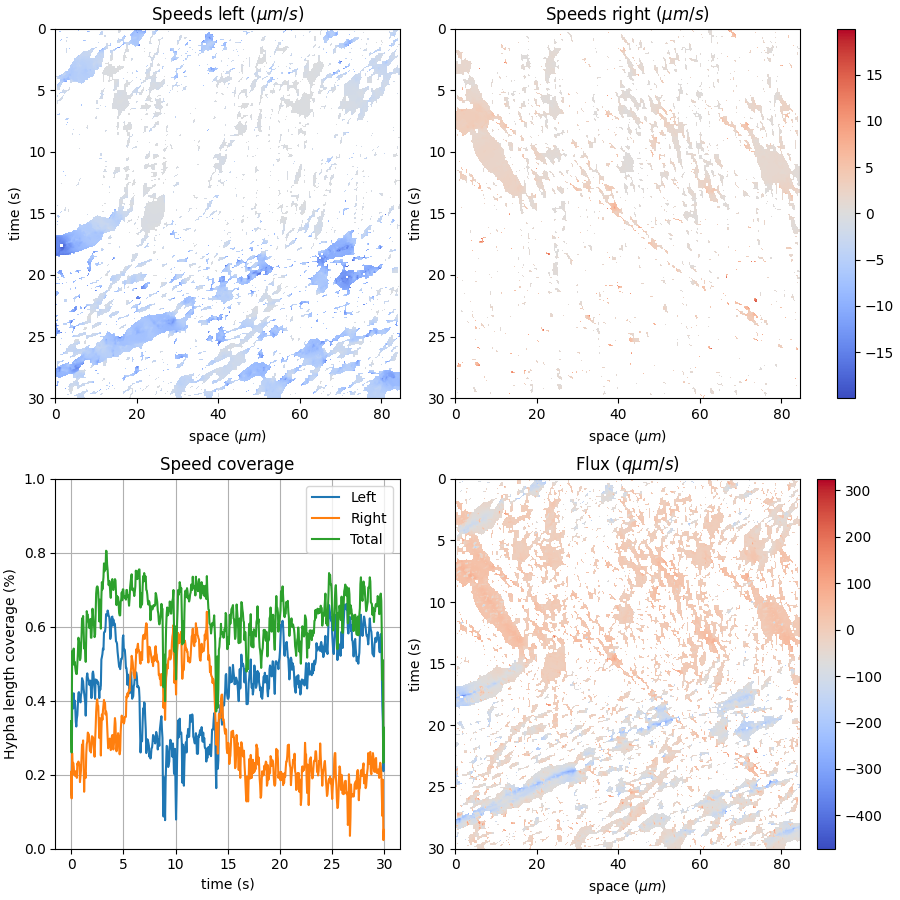

In [15]:
speedmax = np.nanmax(abs(np.array([speeds[0][0], speeds[0][1]])))
# flux_non_nan = ~(np.isnan(speeds[0][0]) * np.isnan(speeds[0][1]))

fig, ax = plt.subplots(2, 2, figsize=(9,9), layout='constrained')
ax[0][0].imshow(speeds[0][0], cmap='coolwarm', aspect='auto', vmax=speedmax, vmin=-speedmax, extent=imshow_extent)
cbar = ax[0][1].imshow(speeds[0][1], cmap='coolwarm', aspect='auto', vmax=speedmax, vmin=-speedmax, extent=imshow_extent)
fig.colorbar(cbar, ax=ax[0,:])
cbar2 = ax[1][1].imshow(net_trans, cmap='coolwarm', aspect='auto', extent=imshow_extent)
fig.colorbar(cbar2, ax=ax[1][1])
ax[1][0].plot(times[0], 1 - np.count_nonzero(np.isnan(speeds[0][0]), axis=1) / len(net_trans[0]), label="Left")
ax[1][0].plot(times[0], 1 - np.count_nonzero(np.isnan(speeds[0][1]), axis=1) / len(net_trans[0]), label="Right")
ax[1][0].plot(times[0], 1 - np.count_nonzero(np.isnan(net_trans), axis=1) / len(net_trans[0]), label="Total")

ax[1][0].set_ylim([0, 1])
ax[1][0].legend()
ax[1][0].grid(True)
ax[1][0].set_title("Speed coverage")
ax[1][0].set_xlabel("time (s)")
ax[1][0].set_ylabel("Hypha length coverage (%)")

ax[0][0].set_title("Speeds left ($\mu m / s$)")
ax[0][0].set_xlabel("space $(\mu m)$")
ax[0][0].set_ylabel("time (s)")
ax[0][1].set_title("Speeds right ($\mu m / s$)")
ax[0][1].set_xlabel("space $(\mu m)$")
ax[0][1].set_ylabel("time (s)")
ax[1][1].set_title("Flux ($q\mu m / s$)")
ax[1][1].set_xlabel("space $(\mu m)$")
ax[1][1].set_ylabel("time (s)")

# fig.tight_layout()

In [21]:
spds_tiff = np.array([
    speeds[0][0],
    speeds[0][1],
    net_trans
], dtype=float)
imwrite("/gpfs/scratch1/shared/amftrackflow/Drp_downs/20230126_Plate527/20230126_Plate527_03/Analysis/edge (840, 306)/speeds_flux_array.tiff", spds_tiff, photometric='minisblack')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


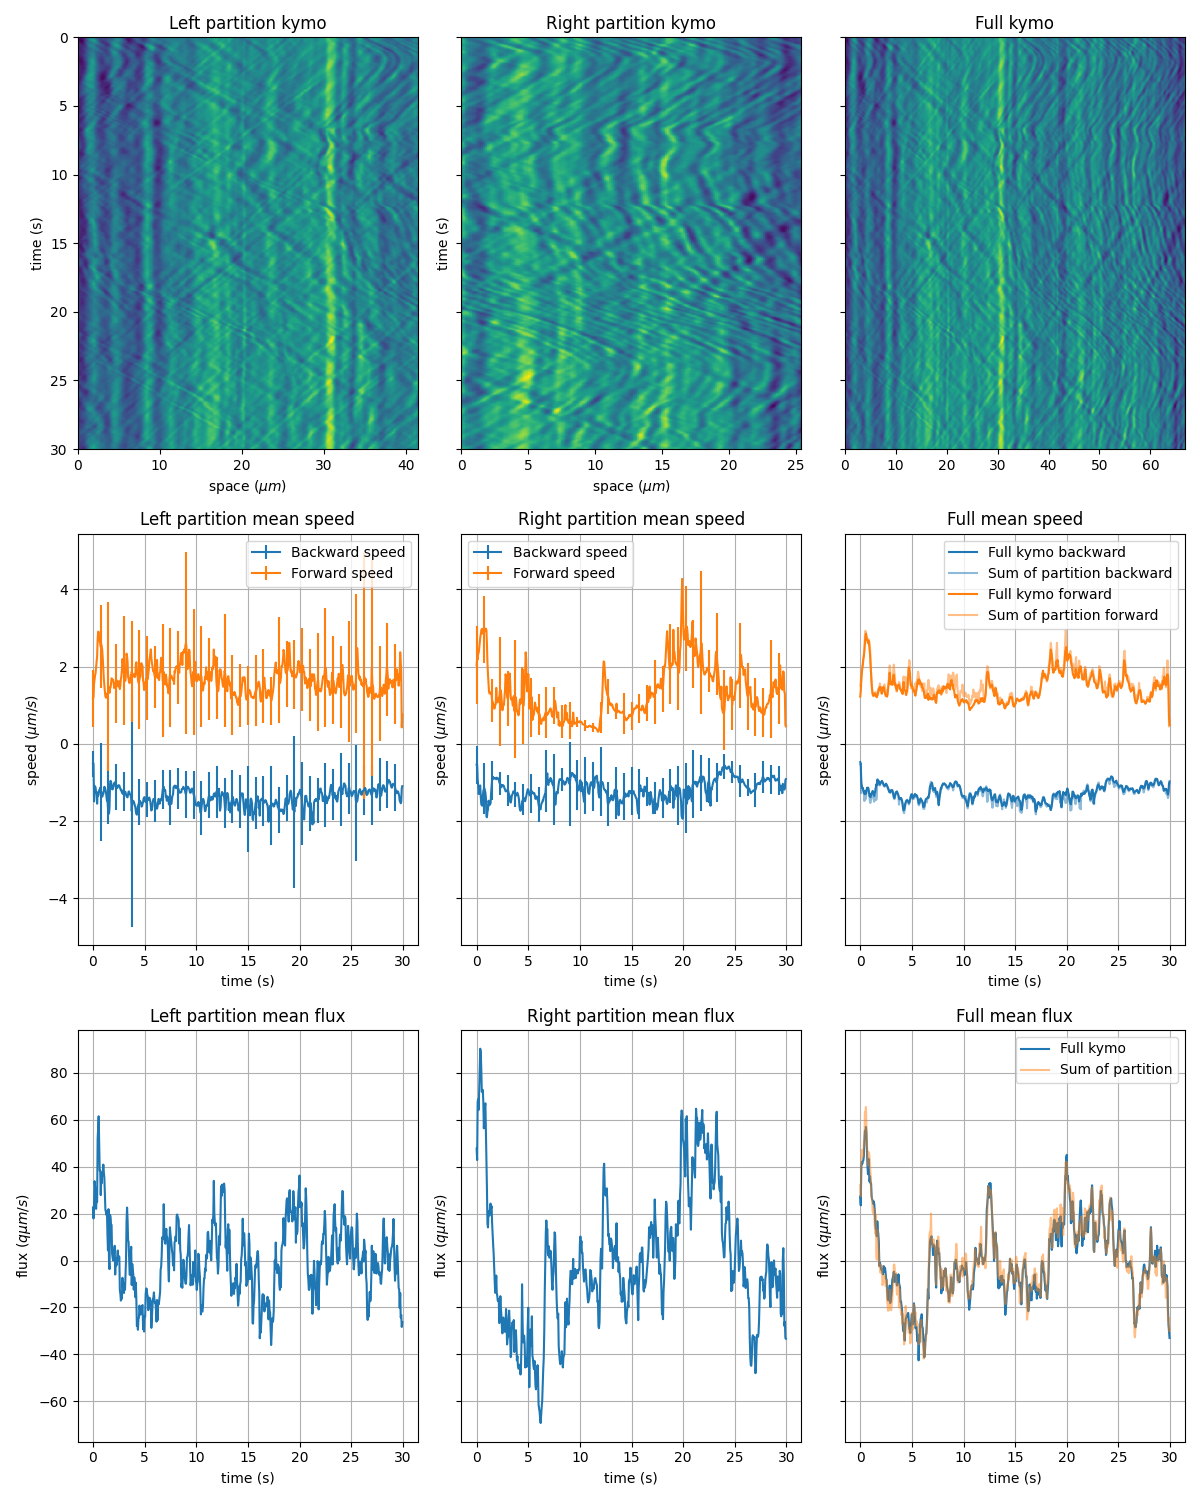

In [6]:


total_len = video_kymos[0].shape[1]
split_index = 300
split_invers = total_len - split_index

split_kymo = [video_kymos[0].T[:split_index].T, video_kymos[0].T[split_index:].T]

kymo_edge_list = [Kymo_edge_analysis(kymo=kymo) for kymo in split_kymo]

fig, ax = plt.subplots(3, 3, figsize=(12,15), sharey='row')
net_speeds = []
net_net_trans = []

for i, kymo_anal in enumerate(tqdm(kymo_edge_list)):
    title = f"({i}, {i+1})"
    
    imshow_extent = [0, space_res * kymo_anal.kymo.shape[1],
                time_res * kymo_anal.kymo.shape[0], 0]
    kymo_anal.space_pixel_size = space_res
    kymo_anal.time_pixel_size = time_res
    
    forw_thresh, back_thresh = kymo_anal.fourier_kymo(1, test_plots=False)
    
    speeds_split, times = kymo_anal.test_GST(15, w_start=3, C_thresh=0.95, C_thresh_falloff = 0.001, blur_size = 3, preblur=True, speed_thresh=50, plots=False)
    net_trans_split = kymo_anal.extract_transport(noise_thresh=0.15, plots=False, save_im=False, save_flux_array=False, save_filters=False, margin=5)    
    
    net_net_trans.append(net_trans_split)
    net_speeds.append(speeds_split)
    ax[0][i].imshow(kymo_anal.kymo, extent=imshow_extent, aspect='auto')
    ax[0][i].set_title(f"{['Left','Right'][i]} partition kymo")
    ax[0][i].set_xlabel("space ($\mu m$)")
    ax[0][i].set_ylabel("time (s)")

    ax[1][i].errorbar(times[0], np.nanmean(speeds_split[0][0], axis=1), np.nanstd(speeds_split[0][0], axis=1), label='Backward speed', errorevery=15)
    ax[1][i].errorbar(times[0], np.nanmean(speeds_split[0][1], axis=1), np.nanstd(speeds_split[0][1], axis=1), label= 'Forward speed', errorevery=15)
    ax[1][i].set_title(f"{['Left','Right'][i]} partition mean speed")
    ax[1][i].set_xlabel("time (s)")
    ax[1][i].set_ylabel("speed ($\mu m/s$)")
    ax[1][i].legend()
    ax[1][i].grid(True)


    ax[2][i].plot(times[0], np.nanmean(net_trans_split, axis=1))        
    ax[2][i].set_title(f"{['Left','Right'][i]} partition mean flux")
    ax[2][i].set_xlabel("time (s)")
    ax[2][i].set_ylabel("flux ($q \mu m / s$)")
    ax[2][i].grid(True)




# net_speeds = np.array(speeds)
speed_mean = [np.nanmean(speed[0][0], axis=1) for speed in net_speeds]

imshow_extent = [0, space_res * video_kymos[0].shape[1],
            time_res * video_kymos[0].shape[0], 0]

ax[0][2].imshow(video_kymos[0], extent=imshow_extent, aspect='auto')
ax[0][2].set_title("Full kymo")
ax[1][2].plot(times[0], np.nanmean(speeds[0][0], axis=1), c='tab:blue', label='Full kymo backward')
ax[1][2].plot(times[0], np.sum([np.nanmean(speed[0][0], axis=1)*([split_index/total_len, split_invers/total_len][i]) for i, speed in enumerate(net_speeds)], axis=0), alpha=0.5, c='tab:blue', label='Sum of partition backward')

ax[1][2].plot(times[0], np.nanmean(speeds[0][1], axis=1), c='tab:orange', label='Full kymo forward')
ax[1][2].plot(times[0], np.sum([np.nanmean(speed[0][1], axis=1)*([split_index/total_len, split_invers/total_len][i]) for i, speed in enumerate(net_speeds)], axis=0), alpha=0.5, c='tab:orange', label='Sum of partition forward')


ax[1][2].set_title(f"Full mean speed")
ax[1][2].set_xlabel("time (s)")
ax[1][2].set_ylabel("speed ($\mu m/s$)")
ax[1][2].legend()
ax[1][2].grid(True)
ax[2][2].plot(times[0], np.nanmean(net_trans, axis=1), label='Full kymo')
ax[2][2].plot(times[0], np.sum([np.nanmean(net_net_trans_t, axis=1)*([split_index/total_len, split_invers/total_len][i]) for i, net_net_trans_t in enumerate(net_net_trans)], axis=0), alpha=0.5, label='Sum of partition')
ax[2][2].set_title(f"Full mean flux")
ax[2][2].set_xlabel("time (s)")
ax[2][2].set_ylabel("flux ($q \mu m / s$)")
ax[2][2].legend()
ax[2][2].grid(True)

fig.tight_layout()




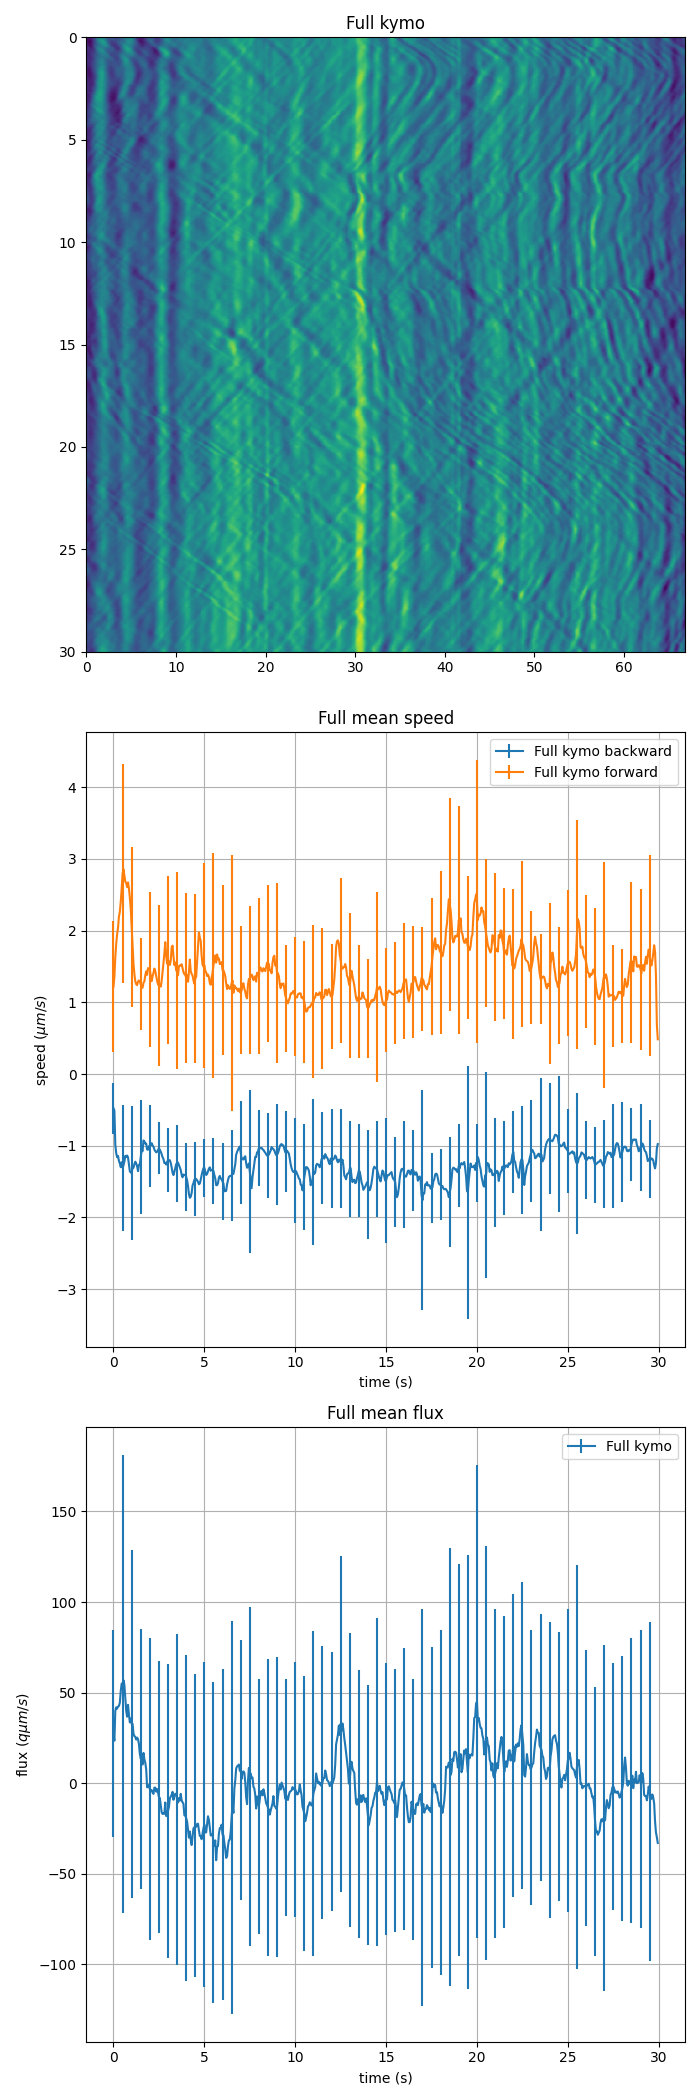

In [16]:


total_len = video_kymos[0].shape[1]
# split_index = 300
# split_invers = total_len - split_index

# split_kymo = [video_kymos[0].T[:split_index].T, video_kymos[0].T[split_index:].T]

# kymo_edge_list = [Kymo_edge_analysis(kymo=kymo) for kymo in split_kymo]

fig, ax = plt.subplots(3, figsize=(7,7*3))
net_speeds = []
net_net_trans = []

# for i, kymo_anal in enumerate(tqdm(kymo_edge_list)):
#     title = f"({i}, {i+1})"
    
#     imshow_extent = [0, space_res * kymo_anal.kymo.shape[1],
#                 time_res * kymo_anal.kymo.shape[0], 0]
#     kymo_anal.space_pixel_size = space_res
#     kymo_anal.time_pixel_size = time_res
    
#     forw_thresh, back_thresh = kymo_anal.fourier_kymo(1, test_plots=False)
    
#     speeds_split, times = kymo_anal.test_GST(15, w_start=3, C_thresh=0.95, C_thresh_falloff = 0.001, blur_size = 3, preblur=True, speed_thresh=50, plots=False)
#     net_trans_split = kymo_anal.extract_transport(noise_thresh=0.15, plots=False, save_im=False, save_flux_array=False, save_filters=False, margin=5)    
    
#     net_net_trans.append(net_trans_split)
#     net_speeds.append(speeds_split)


# net_speeds = np.array(speeds)
speed_mean = [np.nanmean(speed[0][0], axis=1) for speed in net_speeds]

imshow_extent = [0, space_res * video_kymos[0].shape[1],
            time_res * video_kymos[0].shape[0], 0]

ax[0].imshow(video_kymos[0], extent=imshow_extent, aspect='auto')
ax[0].set_title("Full kymo")
ax[1].errorbar(times[0], np.nanmean(speeds[0][0], axis=1), np.nanstd(speeds[0][0], axis=1), c='tab:blue', label='Full kymo backward', errorevery=10)
# ax[1].plot(times[0], np.sum([np.nanmean(speed[0][0], axis=1)*([split_index/total_len, split_invers/total_len][i]) for i, speed in enumerate(net_speeds)], axis=0), alpha=0.5, c='tab:blue', label='Sum of partition backward')

ax[1].errorbar(times[0], np.nanmean(speeds[0][1], axis=1), np.nanstd(speeds[0][1], axis=1), c='tab:orange', label='Full kymo forward', errorevery=10)
# ax[1].plot(times[0], np.sum([np.nanmean(speed[0][1], axis=1)*([split_index/total_len, split_invers/total_len][i]) for i, speed in enumerate(net_speeds)], axis=0), alpha=0.5, c='tab:orange', label='Sum of partition forward')


ax[1].set_title(f"Full mean speed")
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel("speed ($\mu m/s$)")
ax[1].legend()
ax[1].grid(True)
ax[2].errorbar(times[0], np.nanmean(net_trans, axis=1), np.nanstd(net_trans, axis=1), label='Full kymo', errorevery=10)
# ax[2].plot(times[0], np.sum([np.nanmean(net_net_trans_t, axis=1)*([split_index/total_len, split_invers/total_len][i]) for i, net_net_trans_t in enumerate(net_net_trans)], axis=0), alpha=0.5, label='Sum of partition')
ax[2].set_title(f"Full mean flux")
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("flux ($q \mu m / s$)")
ax[2].legend()
ax[2].grid(True)

fig.tight_layout()



In [28]:
data_table = {'times' : times[0],
              'speed_right_mean' : np.nanmean(speeds[0][1], axis=1), 
              "speed_left_mean" : np.nanmean(speeds[0][0], axis=1),
             'speed_right_std': np.nanstd(speeds[0][0], axis=1),
             'speed_left_std' : np.nanstd(speeds[0][1], axis=1),
             'flux_mean' : np.nanmean(net_trans, axis=1),
             'flux_std' : np.nanstd(net_trans, axis=1),
             'flux_coverage' : np.count_nonzero(net_trans, axis=1) / len(net_trans[0]),
             'speed_left_coverage' : 1 - np.count_nonzero(np.isnan(speeds[0][0]), axis=1) / len(net_trans[0]),
             'speed_right_coverage' : 1- np.count_nonzero(np.isnan(speeds[0][1]), axis=1) / len(net_trans[0])
             }

data_out = pd.DataFrame(data=data_table)
data_out


times  speed_right_mean  speed_left_mean  speed_right_std  \
0     0.00          1.219003        -0.476958         0.355872   
1     0.05          1.357832        -0.510549         0.360344   
2     0.10          1.631327        -0.986866         1.336438   
3     0.15          1.817983        -1.104784         0.873413   
4     0.20          1.947738        -1.160880         0.927117   
..     ...               ...              ...              ...   
595  29.75          1.796309        -1.271503         0.696638   
596  29.80          1.705096        -1.316672         0.751033   
597  29.85          1.373183        -1.240340         0.686573   
598  29.90          0.677190        -1.032399         0.425360   
599  29.95          0.484570        -0.977567         0.447233   

     speed_left_std  flux_mean    flux_std  flux_coverage  \
0          0.909191  27.218595   57.122495       0.638430   
1          0.921230  23.472602   56.889617       0.557851   
2          0.831979  39.945374   88.760613       0.799587   
3          0.835105  41.879811   84.771220       0.789256   
4          0.799226  41.164292   89.268172       0.780992   
..              ...        ...         ...            ...   
595        1.582337 -11.098162  102.653218       0.832645   
596        1.256749 -21.184638   92.188534       0.826446   
597        0.903864 -27.208880   78.153995       0.832645   
598        1.831409 -29.915636   67.796702       0.634298   
599        0.322362 -32.982873   38.773908       0.694215   

     speed_left_coverage  speed_right_coverage  
0               0.386364              0.502066  
1               0.338843              0.398760  
2               0.413223              0.636364  
3               0.429752              0.626033  
4               0.446281              0.601240  
..                   ...                   ...  
595             0.739669              0.429752  
596             0.743802              0.384298  
597             0.737603              0.361570  
598             0.582645              0.208678  
599             0.657025              0.278926  

[600 rows x 10 columns]

In [10]:
# fig, ax = plt.subplots(len(edge_objs), bin_nr, figsize=(6, 12), sharey='row')
# count = 0

# bin_space = np.linspace(0,1, bin_nr+1)

# for i in range(len(edge_objs)):
#     for j in range(bin_nr):
#         if len(edge_objs) > 1:
#             if bin_nr > 1:
#                 ax[i][j].imshow(kymo[i][j])
#                 ax[i][j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}] of edge {edge_objs[i].edge_name}")
#                 ax[i][j].set_xlabel("space ($x$)")
#                 ax[i][j].set_ylabel("time ($t$)")
#             elif bin_nr == 1:
#                 ax[i].imshow(kymo[i][0])
#                 ax[i].set_title(f"Kymo of edge {edge_objs[i].edge_name}")
#                 ax[i].set_xlabel("space ($x$)")
#                 ax[i].set_ylabel("time ($t$)")
                
#         else:
#             if bin_nr == 1:
#                 ax = [ax]
#             ax[j].imshow(kymo[i][j])
#             ax[j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}]")
#             ax[j].set_xlabel("space ($x$)")
#             ax[j].set_ylabel("time ($t$)")

# fig.tight_layout()
# # plt.show()

In [11]:

# fig, ax = plt.subplots(1, bins)
# for i in range(1, 30):
#     for j in range(bins):
#         corr = signal.correlate(kymo[1][0], kymo[1][bins_space[j]:bins_space[j+1]][i])
#         corr /= np.max(corr)
#         lags = signal.correlation_lags(len(kymo[0][0]), len(kymo[0][bins_space[j]:bins_space[j+1]][i]))
#         ax[j].plot(lags, corr)
# plt.show()

In [12]:
# fig, ax = plt.subplots(len(edge_objs), bin_nr, figsize=(6, 12), sharey='row')
# count = 0

# bin_space = np.linspace(0,1, bin_nr+1)

# for i in range(len(edge_objs)):
#     for j in range(bin_nr):
#         if len(edge_objs) > 1:
#             if bin_nr > 1:
#                 ax[i][j].imshow(kymo[i][j])
#                 ax[i][j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}] of edge {edge_objs[i].edge_name}")
#                 ax[i][j].set_xlabel("space ($x$)")
#                 ax[i][j].set_ylabel("time ($t$)")
#             elif bin_nr == 1:
#                 ax[i].imshow(kymo[i][0])
#                 ax[i].set_title(f"Kymo of edge {edge_objs[i].edge_name}")
#                 ax[i].set_xlabel("space ($x$)")
#                 ax[i].set_ylabel("time ($t$)")
                
#         else:
#             if bin_nr == 1:
#                 ax = [ax]
#             ax[j].imshow(kymo[i][j])
#             ax[j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}]")
#             ax[j].set_xlabel("space ($x$)")
#             ax[j].set_ylabel("time ($t$)")

# fig.tight_layout()
# # plt.show()